In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import pyreadr
import pandas as pd
from itertools import product
import multiprocessing as mp
from ml_par import sample_ll, sample_ll_multiple
from scipy.spatial import distance_matrix
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from scipy.stats import norm 
import scipy as sc

# Define functions

In [124]:
def corr_func(h, r, s):
    res = np.exp(-np.power((h/r),s))
    return res    

In [3]:
def s_term(z1, z2, h, r, s):
    res = np.sqrt(1 - 2 * (corr_func(h, r, s)+1) * (z1 * z2)/np.power((z1+z2),2))
    return res

In [4]:
def s_term_dev(z1, z2, h, r, s):
    res = (1/( s_term(z1, z2, h, r, s))) * (-(corr_func(h, r, s) + 1 )) * \
          z2 * (z1+z2) * ((z1+z2)- 2 * z1)/np.power((z1+z2), 4)
    return res

In [5]:
def s_term_dev_2(z1, z2, h, r, s):
    term_1 = (-1/np.power(s_term(z1,z2,h,r,s),2)) * s_term_dev(z2,z1,h,r,s) * \
             (z2/np.power(z1+z2,2) - (2*z1*z2)/np.power(z1+z2,3))
    
    
    term_2 = (1/s_term(z1,z2,h,r,s)) * ((z1-z2)/np.power(z1+z2,3) - (2*z1*z1-4*z1*z2)/np.power(z1+z2,4))
    
    res = -(corr_func(h,r,s)+1)*(term_1+term_2)
    return res

In [6]:
def V(z1, z2, h, r, s):
    res = 0.5 * (1/z1 + 1/z2) * (1 + s_term(z1, z2, h, r, s))
    return res

In [7]:
def V1(z1, z2, h, r, s):
    res = 0.5 * (-1/np.power(z1, 2)*(1+s_term(z1, z2, h, r, s)) + \
                 (1/z1 + 1/z2)*s_term_dev(z1,z2,h,r,s))
    return res

In [8]:
def V2(z1, z2, h, r, s):
    res = V1(z2, z1, h, r, s)
    return res

In [9]:
def V12(z1, z2, h, r, s):
    res = 0.5 * ((-1/np.power(z1,2)) * s_term_dev(z2, z1, h, r, s) + \
          (-1/np.power(z2,2)) * s_term_dev(z1, z2, h, r, s) + (1/z1 + 1/z2) * s_term_dev_2(z1, z2, h, r, s))
    return res

In [10]:
def logl(z1, z2, h, r, s):
    res = np.log(V1(z1, z2, h, r, s) * V2(z1, z2, h, r, s) - V12(z1, z2, h, r, s))- V(z1, z2, h, r, s)
    return res

# Plot functions

In [11]:
z = np.linspace(0.1, 30, 300)

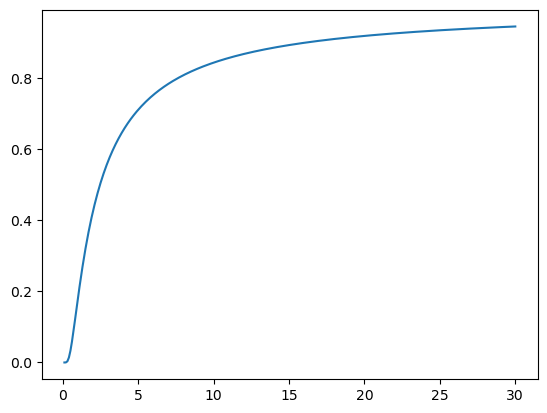

In [109]:
# CDF
y = np.exp(-V(z, z, 20, 2.5, 2))
plt.plot(z,y)

## Analyze bivariate exponent measure

In [188]:
r = 2
s = 1.5
h = 2

In [206]:
z = np.linspace(0.01, 1, 300)
z1, z2 = np.meshgrid(z,z)
v =  np.abs(V(z1, z2, h, 0.5, 1.2) - V(z1, z2, h, 1, 1.5))#V(z1, z2, h, r, s)

In [207]:
v.mean()

0.04627962654924832

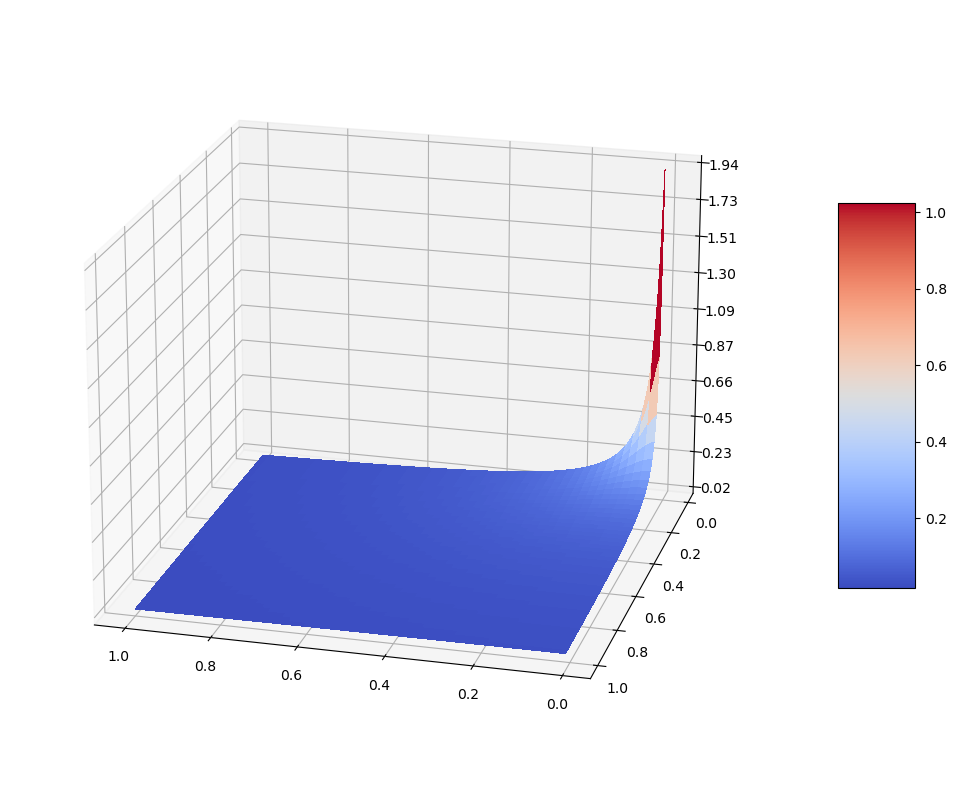

In [208]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize = (15,10))
# Set up plot
surf = ax.plot_surface(z1, z2, v, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)


ax.view_init(20, 105)
plt.show()

In [125]:
# Test integration
f = lambda z1, z2, h: np.abs(V(z1, z2, h, 0.5, 1.2) - V(z1, z2, h, 1, 1.5))

res = integrate.tplquad(f, 0, 40, 0, 15, 0, 15)

In [126]:
res

(172.33893468588917, 6.944312644918682e-07)

# Evalute log likelihood

In [32]:
# Load example data
exp = "exp_4"
path = f'../data/{exp}/data/'
sample = 300
length = 625
test_data = pyreadr.read_r(path+"powexp_test_data.RData")["test_data"].to_numpy()
test_params = pyreadr.read_r(path+"powexp_test_params.RData")["test_params"].to_numpy()
data_sample = test_data[:,sample]
param_sample = test_params[sample]
print(param_sample)

[1.52770268 1.32384734]


In [33]:
x = np.linspace(0,25,25)
grid = np.array(list(product(x, repeat = 2)))

In [34]:
sample_space = 30
r = np.linspace(0.01, 10 ,sample_space)
s = np.linspace(0.01,2, sample_space)
r_plot, s_plot = np.meshgrid(r,s)

In [35]:
param_grid = np.zeros(shape = ((len(r)*len(s)),3))
param_grid[:,0:2] = np.array(list(product(r, s)))

In [36]:
distmat = distance_matrix(grid, grid)
data_expanded = np.repeat(np.expand_dims(data_sample,1), length, axis = 1)

In [37]:
def collect_result(result):
    global param_grid
    data, sample = result    
    param_grid[sample,2] = data

In [38]:
pool = mp.Pool(mp.cpu_count()-1)

In [39]:
# Run parallel
for t in range(sample_space**2):
    result = pool.apply_async(sample_ll, args = (t, param_grid, grid, data_expanded, distmat, 5), callback = collect_result)
pool.close()
pool.join()

In [40]:
z = np.transpose(np.reshape(param_grid[:,2], (len(r), len(s))))

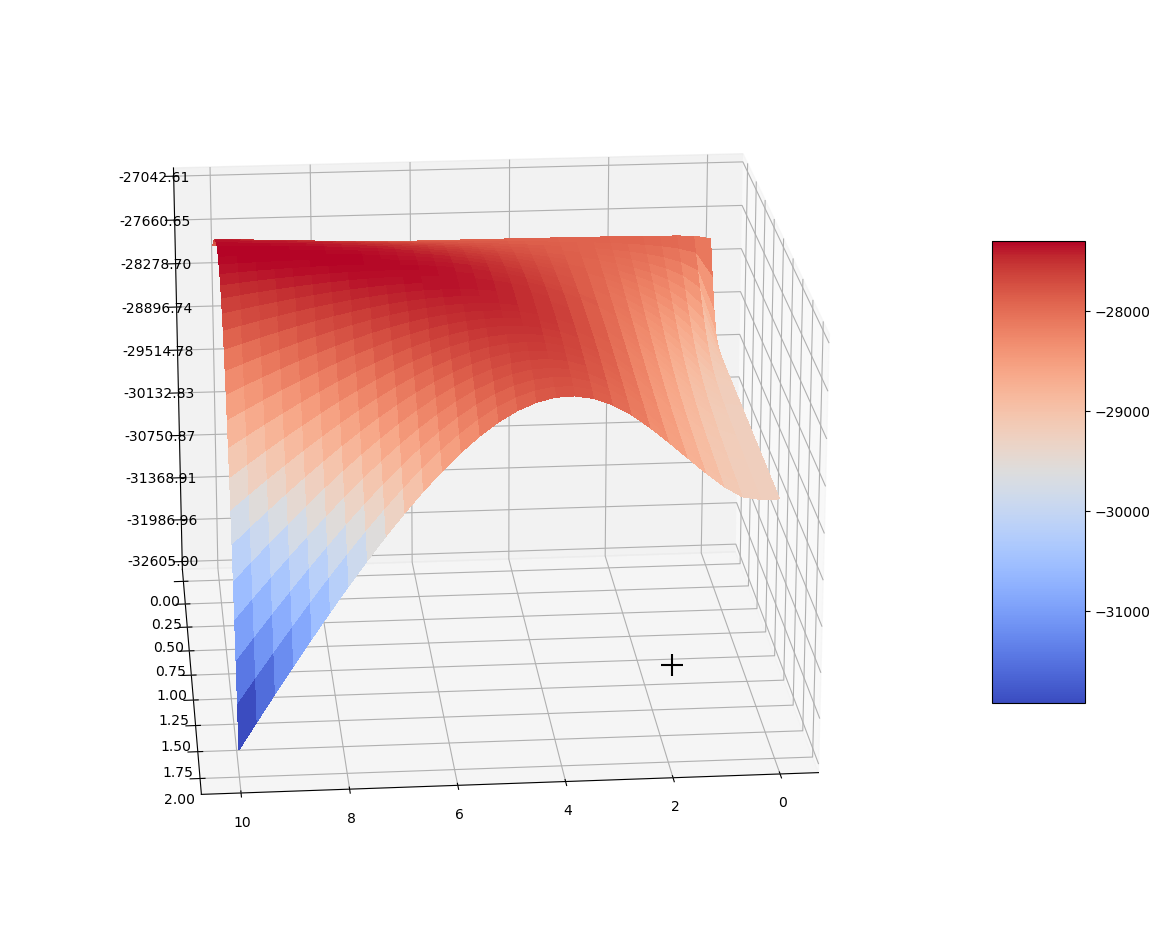

In [41]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize = (15,12))
# Set up plot
surf = ax.plot_surface(r_plot, s_plot, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.scatter(param_sample[0], param_sample[1], z.min(), color = "black", marker = "+", s = 250)


ax.view_init(20, 85)
plt.show()
fig.savefig("../../plots/likelihood_one_sample.pdf", bbox_inches = "tight")

## Minimize objective

In [40]:
from scipy.optimize import minimize

In [41]:
def sample_ll_opt(x, grid, data, distmat, cutoff = 5):
    r = x[0]
    s = x[1]    
    ll = logl(data, np.transpose(data), distmat, r, s)
    res = np.tril(ll, -1)
    res[distmat>=cutoff] = 0

    return -np.sum(res)

In [47]:
x0 = np.array([np.random.uniform(0,10), np.random.uniform(0,2)])
res = minimize(sample_ll_opt, x0, args = (grid, data_expanded, distmat), method = "L-BFGS-B", bounds = [(0.001,10),(0.001,2)])

C:\Users\chris\AppData\Local\Temp\ipykernel_16592\2586202307.py:2: RuntimeWarning: divide by zero encountered in divide
  res = (1/( s_term(z1, z2, h, r, s))) * (-(corr_func(h, r, s) + 1 )) * \
C:\Users\chris\AppData\Local\Temp\ipykernel_16592\2586202307.py:2: RuntimeWarning: invalid value encountered in multiply
  res = (1/( s_term(z1, z2, h, r, s))) * (-(corr_func(h, r, s) + 1 )) * \
C:\Users\chris\AppData\Local\Temp\ipykernel_16592\1604938214.py:6: RuntimeWarning: divide by zero encountered in divide
  term_2 = (1/s_term(z1,z2,h,r,s)) * ((z1-z2)/np.power(z1+z2,3) - (2*z1*z1-4*z1*z2)/np.power(z1+z2,4))


In [48]:
res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 112545.57190559804
        x: [ 1.556e+00  1.278e+00]
      nit: 8
      jac: [-3.492e-02  3.347e-02]
     nfev: 30
     njev: 10
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

# Calculate likelihood with multiple samples

In [42]:
sample_space = 20
r = np.linspace(0.01, 5 ,sample_space)
s = np.linspace(0.01,2, sample_space)
r_plot, s_plot = np.meshgrid(r,s)

In [43]:
param_grid_2 = np.zeros(shape = ((len(r)*len(s)),3))
param_grid_2[:,0:2] = np.array(list(product(r, s)))

In [44]:
data_sample = test_data[:,sample:sample+30]
param_sample = test_params[sample]

In [45]:
data_expanded = np.repeat(np.expand_dims(data_sample,2), length, axis = 2)

In [46]:
def collect_result(result):
    global param_grid_2
    data, sample = result    
    param_grid_2[sample,2] = data

In [47]:
pool = mp.Pool(mp.cpu_count()-1)

In [48]:
# Run parallel
for t in range(sample_space**2):
    result = pool.apply_async(sample_ll_multiple, args = (t, param_grid_2, grid, data_expanded, distmat, 5), callback = collect_result)
pool.close()
pool.join()

In [49]:
z2 = np.transpose(np.reshape(param_grid_2[:,2], (len(r), len(s))))

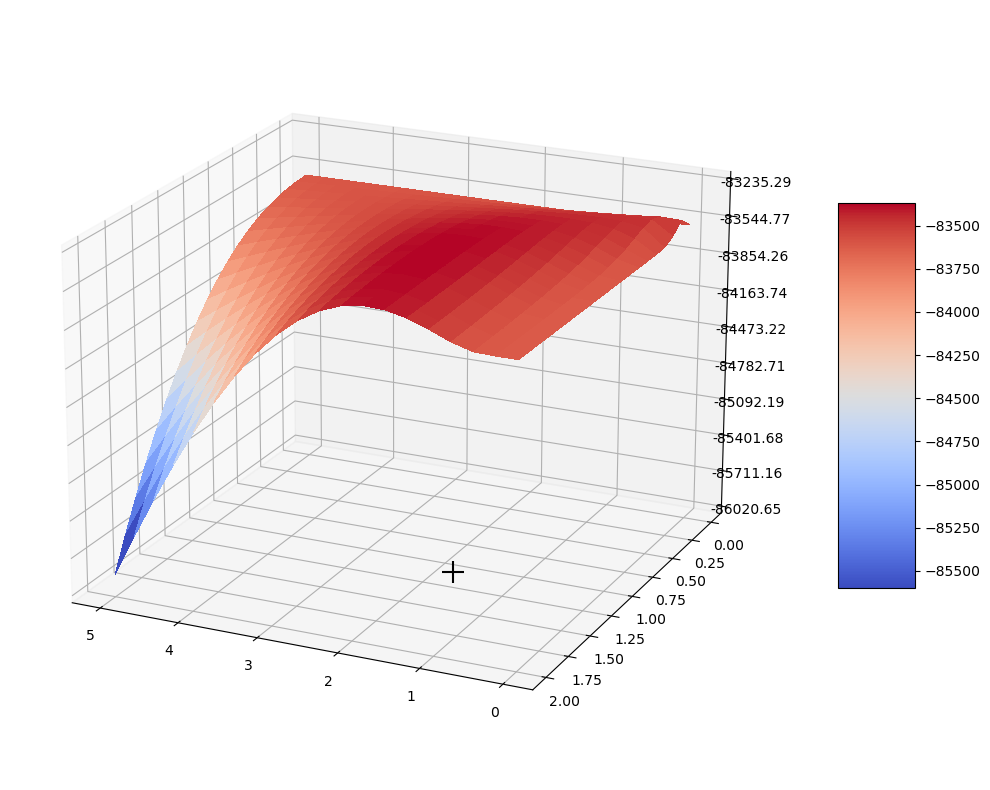

In [50]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize = (15,10))
# Set up plot
surf = ax.plot_surface(r_plot, s_plot, z2, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.scatter(param_sample[0], param_sample[1], z2.min(), color = "black", marker = "+", s = 250)


ax.view_init(20, 115)
plt.show()
fig.savefig("../../plots/likelihood_multiple_sample.pdf", bbox_inches = "tight")

In [58]:
param_sample

array([2.85595263, 0.85128205])

In [2]:
def corr_func(h: float, model: str, r: float, s: float) -> float:
    """Calculates the correlation function (powexp, whitmat) or the variogram (brown) depending on the model parameters
    and distance h.

    Args:
        h (float): Distance or array of distances
        model (str): String describing the underlying model
        r (float): Range parameter
        s (float): _Smoothness parameter
    Returns:
        float: Returns value of correlation function / variogram
    """
    if model == "brown":
        res = np.power((h / r), s)
    elif model == "powexp":
        res = np.exp(-np.power((h / r), s))
    elif model == "whitmat":
        res = (
            np.power(2, (1 - s))
            / sc.special.gamma(s)
            * np.power((h / r), 2)
            * sc.special.kv(s, (h / r))
        )
    return res

# Brown-Resnick

In [41]:
def bivariate_cdf(z1,z2, h, model, r, s):
    rho = corr_func(h, model, r, s)
    if model == "brown":
        a = np.sqrt(rho)
        Phi = lambda z1, z2: norm.cdf(a/2 + (1/a)*(np.log(z2/z1)))        
        V = (1/z1) * Phi(z1,z2) + (1/z2) * Phi(z2,z1)
    else:
        V = 0.5 * (1/z1 + 1/z2) * (1 + np.sqrt(1 - (2*(1+rho)*z1*z2)/(np.power(z1+z2,2))))
    cdf = np.exp(-V)
    return cdf

In [48]:
def bivariate_density(z1, z2, h, model, r, s):
      rho = corr_func(h, model, r, s)

      #Brown-Resnick
      if model == "brown":
            rho = np.sqrt(rho)
            #Define helping terms
            phi = lambda z1, z2, a: 1/(np.sqrt(2*np.pi))*np.exp(-0.5 * np.power(a/2 + (1/a)*(np.log(z2/z1)),2))
            Phi = lambda z1, z2, a: sc.special.ndtr(a/2 + (1/a)*(np.log(z2/z1)))

            V = lambda z1, z2, a: (1/z1) * Phi(z1,z2,a) + (1/z2) * Phi(z2,z1,a)
            V1 = lambda z1, z2, a: (-1/np.power(z1,2)) * Phi(z1,z2,a) - (1/(a*np.power(z1,2))) * phi(z1,z2,a) + (1/(a*z1*z2)) * phi(z2,z1,a)
            V12 = lambda z1, z2, a:  (-1/(a*z2*np.power(z1,2))) *phi(z1,z2,a) + (1/(np.power(a,2)*z2*np.power(z1,2))) * phi(z1,z2,a) * (a/2 + 1/a * np.log(z2/z1)) - (1/(np.power(z2,2) * a * z1)) * phi(z2,z1,a) + (1/(z1 * np.power(z2,2)*np.power(a,2))) * phi(z2,z1,a) * (a/2 + 1/a * np.log(z1/z2))

      #Schlather
      else:          
          V = lambda z1, z2, rho: 0.5 * (1/z1 + 1/z2) * (1 + 1/(z1+z2) * np.sqrt(np.power(z1,2) - 2 * z1 * z2 * rho + np.power(z2,2)))
          V1 = lambda z1, z2, rho: -1/(2*np.power(z1,2)) + 1/2 * (rho/z1 - z2 / np.power(z1,2)) * np.power(np.power(z1,2) -2*z1 * z2 * rho + np.power(z2,2), -0.5)
          V12 = lambda z1, z2, rho: -1/2 * (1- np.power(rho,2)) * (np.power(np.power(z1,2) - 2 *z1 *z2 * rho + np.power(z2,2), -3/2))

      density = np.exp(-V(z1,z2,rho)) * (V1(z1,z2,rho)*V1(z2,z1,rho) - V12(z1,z2,rho))
      return density

# Schlather

In [148]:
def V(z1, z2, h, r, s):
    rho = np.exp(-np.power((h/r),s))
    res = 0.5 * (1/z1 + 1/z2) * (1 + np.sqrt(1 - (2*(1+rho)*z1*z2)/(np.power(z1+z2,2))))
    return res

In [137]:
def bivariate_density(z1, z2, h, model, r, s):
    rho = np.exp(-np.power((h/r),s))

    V = lambda z1, z2, rho: 0.5 * (1/z1 + 1/z2) * (1 + 1/(z1+z2) * np.sqrt(np.power(z1,2) - 2 * z1 * z2 * rho + np.power(z2,2)))
    V1 = lambda z1, z2, rho: -1/(2*np.power(z1,2)) + 1/2 * (rho/z1 - z2 / np.power(z1,2)) * np.power(np.power(z1,2) -2*z1 * z2 * rho + np.power(z2,2), -0.5)
    V12 = lambda z1, z2, rho: -1/2 * (1- np.power(rho,2)) * (np.power(np.power(z1,2) - 2 *z1 *z2 * rho + np.power(z2,2), -3/2))

    density = np.exp(-V(z1,z2,rho)) * (V1(z1,z2,rho)*V1(z2,z1,rho) - V12(z1,z2,rho))
    return density
    

# Test functions

In [50]:
h = 4
r = 2
s = 1.5
model = "brown"
z1 = 4
z2 = 5

true = bivariate_cdf(z1, z2, h, model, r, s)
true

0.6970936261224079

In [53]:
f = lambda z1, z2: bivariate_density(z1, z2, h, model, r, s)
res = integrate.dblquad(f, 0, z1, 0, z2)
res

(0.6970936261225573, 1.4099852764793135e-08)

In [15]:
# Test integration
f = lambda z1, z2: density(z1, z2, h, r, s)

res = integrate.dblquad(f, 0, 4, 0, 1)
res

(0.3648923255652908, 1.4267648069931437e-08)

In [16]:
z = np.linspace(0.1, 30, 300)

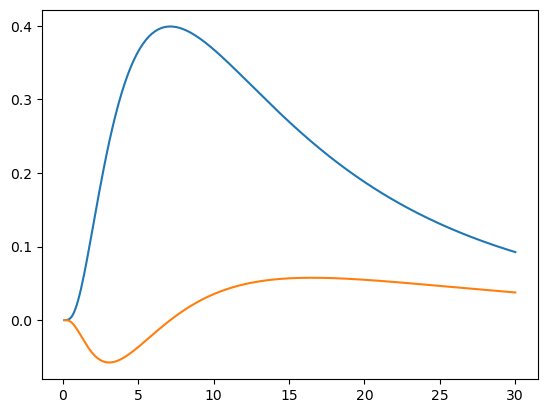

In [17]:
# CDF
y1 = phi(z,5,a)
y2 = phi_dev(z,5,a)
plt.plot(z,y1)
plt.plot(z, y2)